In [35]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import serial.tools.list_ports
import math

# https://www.mirkosertic.de/blog/2023/01/magnetometer-calibration-ellipsoid/

array_size = 1000
input_data = np.zeros((3, array_size))

# Get a list of all available COM ports
ports = list(serial.tools.list_ports.comports())

# Iterate through the list of ports and check if Arduino is connected
arduino_port = None
for port in ports:
    print(port)
    #if "USB-SERIAL" in port.description:
    # if "Arduino" in port.description:
    if "USB" in port.description:
        arduino_port = port.device
        break

# If Arduino is found, establish a serial connection
if arduino_port:
    try:
        ser = serial.Serial(arduino_port, 9600)  # Replace 9600 with your desired baud rate
        print("Serial connection established with Arduino on port:", arduino_port)
        
        i=0
        while i < array_size:
            # Read a line of data from the serial connection
            line = ser.readline().decode("utf-8").strip()
            # print(line)
            # Parse line into a numpy array
            serial_array = np.fromstring(line, dtype=float, sep=',')
            # print(data_array)
            if ((serial_array.size == 3)):
                input_data[0, i] = serial_array[0]
                input_data[1, i] = serial_array[1]
                input_data[2, i] = serial_array[2]
                i+=1

        ser.close()  # Close the serial connection when done
    except serial.SerialException as e:
        print("Failed to establish serial connection:", str(e))
else:
    print("Arduino not found on any COM port.")

/dev/cu.usbserial-0001 - CP2102 USB to UART Bridge Controller
Serial connection established with Arduino on port: /dev/cu.usbserial-0001


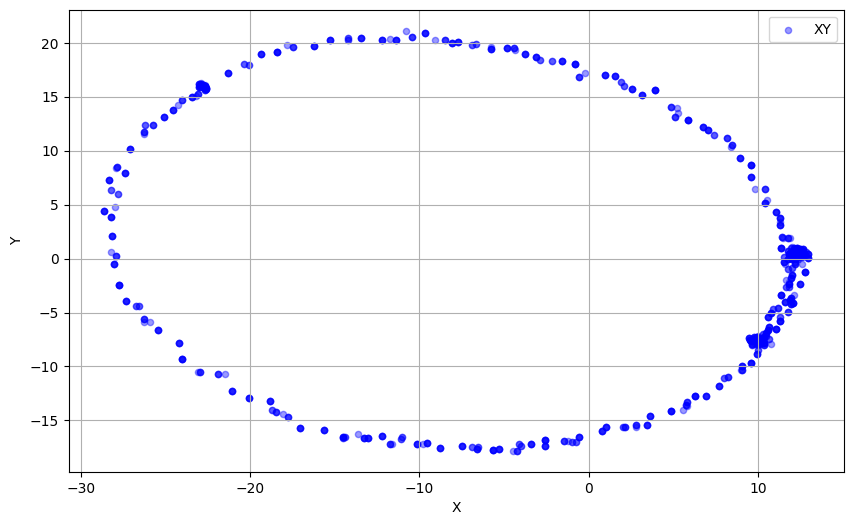

In [36]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
X=input_data[0]-np.mean(input_data[0])
Y=input_data[1]-np.mean(input_data[1])
ax.scatter(X, Y, marker="o", c="blue", s=20, alpha=0.4, label = "XY")
plt.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
# ax.scatter(input_data[1], input_data[2], c='g', label = "YZ")
# ax.scatter(input_data[2], input_data[0], c='r', label = "ZX")
plt.grid()

plt.show()


Fitted parameters:
a, b, c, d, e, f = [-6.45346981e-01 -1.35101197e-01 -7.51847684e-01 -1.05226835e+01
  9.74884765e-01  2.20316538e+02]
x0, y0, ap, bp, e, phi =  -8.298640083858855 1.3939266028550261 20.785499925902485 18.36600781355867 0.46824794128845304 2.689978454184686
// a, b, c, d, e = 0.8997438084310719 0.4364184679753487 1.1317375086031287 -8.298640083858855 1.3939266028550261
static float a = 0.8997438084310719;
static float b = 0.4364184679753487;
static float c = 1.1317375086031287;
static float d = -21.590995883858856;
static float e = 9.817197302855027;


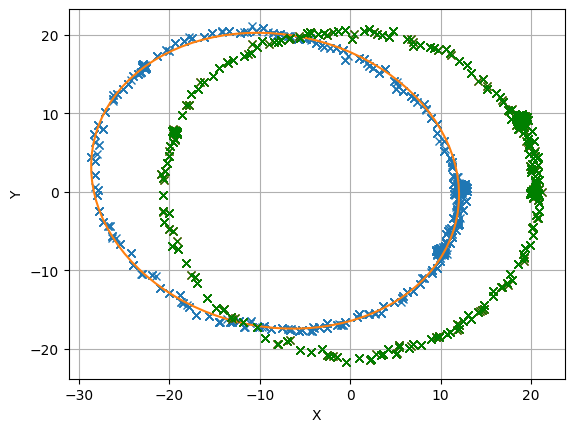

In [37]:
def fit_ellipse(x, y):
    """
    Fit the coefficients a,b,c,d,e,f, representing an ellipse described by
    the formula F(x,y) = ax^2 + bxy + cy^2 + dx + ey + f = 0 to the provided
    arrays of data points x=[x1, x2, ..., xn] and y=[y1, y2, ..., yn].

    Based on the algorithm of Halir and Flusser, "Numerically stable direct
    least squares fitting of ellipses'.
    """

    D1 = np.vstack([x**2, x*y, y**2]).T
    D2 = np.vstack([x, y, np.ones(len(x))]).T
    S1 = D1.T @ D1
    S2 = D1.T @ D2
    S3 = D2.T @ D2
    T = -np.linalg.inv(S3) @ S2.T
    M = S1 + S2 @ T
    C = np.array(((0, 0, 2), (0, -1, 0), (2, 0, 0)), dtype=float)
    M = np.linalg.inv(C) @ M
    eigval, eigvec = np.linalg.eig(M)
    con = 4 * eigvec[0]* eigvec[2] - eigvec[1]**2
    ak = eigvec[:, np.nonzero(con > 0)[0]]
    return np.concatenate((ak, T @ ak)).ravel()


def cart_to_pol(coeffs):
    """
    Convert the cartesian conic coefficients, (a, b, c, d, e, f), to the
    ellipse parameters, where F(x, y) = ax^2 + bxy + cy^2 + dx + ey + f = 0.
    The returned parameters are x0, y0, ap, bp, e, phi, where (x0, y0) is the
    ellipse centre; (ap, bp) are the semi-major and semi-minor axes,
    respectively; e is the eccentricity; and phi is the rotation of the semi-
    major axis from the x-axis.
    """

    # We use the formulas from https://mathworld.wolfram.com/Ellipse.html
    # which assumes a cartesian form ax^2 + 2bxy + cy^2 + 2dx + 2fy + g = 0.
    # Therefore, rename and scale b, d and f appropriately.
    a = coeffs[0]
    b = coeffs[1] / 2
    c = coeffs[2]
    d = coeffs[3] / 2
    f = coeffs[4] / 2
    g = coeffs[5]

    den = b**2 - a*c
    if den > 0:
        raise ValueError('coeffs do not represent an ellipse: b^2 - 4ac must'
                         ' be negative!')

    # The location of the ellipse centre.
    x0, y0 = (c*d - b*f) / den, (a*f - b*d) / den

    num = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
    fac = np.sqrt((a - c)**2 + 4*b**2)
    # The semi-major and semi-minor axis lengths (these are not sorted).
    ap = np.sqrt(num / den / (fac - a - c))
    bp = np.sqrt(num / den / (-fac - a - c))

    # Sort the semi-major and semi-minor axis lengths but keep track of
    # the original relative magnitudes of width and height.
    width_gt_height = True
    if ap < bp:
        width_gt_height = False
        ap, bp = bp, ap

    # The eccentricity.
    r = (bp/ap)**2
    if r > 1:
        r = 1/r
    e = np.sqrt(1 - r)

    # The angle of anticlockwise rotation of the major-axis from x-axis.
    if b == 0:
        phi = 0 if a < c else np.pi/2
    else:
        phi = np.arctan((2.*b) / (a - c)) / 2
        if a > c:
            phi += np.pi/2
    if not width_gt_height:
        # Ensure that phi is the angle to rotate to the semi-major axis.
        phi += np.pi/2
    phi = phi % np.pi

    return x0, y0, ap, bp, e, phi


def get_ellipse_pts(params, npts=100, tmin=0, tmax=2*np.pi):
    """
    Return npts points on the ellipse described by the params = x0, y0, ap,
    bp, e, phi for values of the parametric variable t between tmin and tmax.
    """

    x0, y0, ap, bp, e, phi = params
    # A grid of the parametric variable, t.
    t = np.linspace(tmin, tmax, npts)
    x = x0 + ap * np.cos(t) * np.cos(phi) - bp * np.sin(t) * np.sin(phi)
    y = y0 + ap * np.cos(t) * np.sin(phi) + bp * np.sin(t) * np.cos(phi)
    return x, y


if __name__ == '__main__':
    X=input_data[0]-np.mean(input_data[0])
    Y=input_data[1]-np.mean(input_data[1])

    coeffs = fit_ellipse(X, Y)

    print('Fitted parameters:')
    print('a, b, c, d, e, f =', coeffs)
    x0, y0, ap, bp, e, phi = cart_to_pol(coeffs)
    print('x0, y0, ap, bp, e, phi = ', x0, y0, ap, bp, e, phi)

    plt.plot(X, Y, 'x')     # given points

    x, y = get_ellipse_pts((x0, y0, ap, bp, e, phi))
    plt.plot(x, y)

    rat = ap / bp

    rot = round(phi / (math.pi / 2.0))
    rotation = -(phi - rot * math.pi / 2.0)

    a = np.cos(rotation)
    b = np.sin(rotation)
    c = ap/bp
    d = x0
    e = y0

    print('// a, b, c, d, e =', a,b,c,d,e)
    print(f"static float a = {a};")
    print(f"static float b = {b};")
    print(f"static float c = {c};")
    print(f"static float d = {d + np.mean(input_data[0])};")
    print(f"static float e = {e + np.mean(input_data[1])};")
    
    xcorr = (X - d) * a - (Y - e) * b
    ycorr = ((X - d) * b + (Y - e) * a) * c

    xcorr2 = (input_data[0] - (d + np.mean(input_data[0]))) * a - (input_data[1] - (e + np.mean(input_data[1]))) * b
    ycorr2 = ((input_data[0] - (d + np.mean(input_data[0]))) * b + (input_data[1] - (e + np.mean(input_data[1]))) * a) * c
    

    plt.plot(xcorr, ycorr, 'x', color="red")     # given points
    plt.plot(xcorr2, ycorr2, 'x', color="g")     # given points

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()

    plt.show()

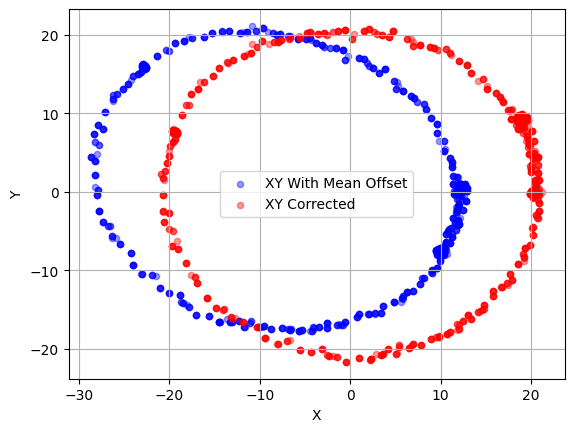

In [38]:
X=input_data[0]-np.mean(input_data[0])
Y=input_data[1]-np.mean(input_data[1])
plt.scatter(X, Y, marker="o", c="blue", s=20, alpha=0.4, label = "XY With Mean Offset")
plt.scatter(xcorr, ycorr, marker="o", c="red", s=20, alpha=0.4, label = "XY Corrected")

plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()

plt.show()